**Dataset Information**

Helmet - No helmet detection - v1 2024-07-27 5:55am  
This dataset was exported via roboflow.com on July 27, 2024 at 5:57 AM GMT

https://universe.roboflow.com/programa-delfn/helmet-no-helmet-detection-hjdvx  

Provided by a Roboflow user  
License: CC BY 4.0

The dataset includes 3341 images.  
Helmet-no-helmet are annotated in YOLO format.

The following pre-processing was applied to each image:
* Auto-orientation of pixel data (with EXIF-orientation stripping)
* Resize to 640x640 (Fit within)

The following augmentation was applied to create 2 versions of each source image:
* Salt and pepper noise was applied to 0.5 percent of pixels

Directory Structure:  
cv-project/  
└── detection/  
│   ├── datasets/  
│   │   ├── train/  
│   │   │   ├── images/  
│   │   │   └── labels/  
│   │   └── valid/  
│   │       ├── images/  
│   │       └── labels/  
│   ├── data.yaml  
│   ├── main.ipynb  
│   ├── README.dataset.txt  
│   └── README.roboflow.txt  
└── proposal.pdf

In [16]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


dataset_path = 'datasets'

class_id_map = {0 : 'with_helmet', 1 : 'without_helmet'}

train_images_dir = os.path.join(dataset_path, 'train/images')
train_labels_dir = os.path.join(dataset_path, 'train/labels')
val_images_dir = os.path.join(dataset_path, 'valid/images')
val_labels_dir = os.path.join(dataset_path, 'valid/labels')

train_images = set(os.listdir(train_images_dir))
train_labels = set(os.listdir(train_labels_dir))
val_images = set(os.listdir(val_images_dir))
val_labels = set(os.listdir(val_labels_dir))

print(f"Train images: {len(train_images)}")
print(f"Validation images: {len(val_images)}")

Train images: 2862
Validation images: 477


In [3]:
#checking if we have one to one mapping between images and labels in the dataset
def check_label_matching(image_set, label_set):
    image_names = {img.split('.')[0] for img in image_set}
    label_names = {lbl.split('.')[0] for lbl in label_set}
    missing_labels = image_names - label_names
    missing_images = label_names - image_names
    return missing_labels, missing_images

train_missing_labels, train_missing_images = check_label_matching(train_images, train_labels)
val_missing_labels, val_missing_images = check_label_matching(val_images, val_labels)

print(f"Train set - Missing labels: {len(train_missing_labels)}, Missing images: {len(train_missing_images)}")
print(f"Validation set - Missing labels: {len(val_missing_labels)}, Missing images: {len(val_missing_images)}")

Train set - Missing labels: 0, Missing images: 0
Validation set - Missing labels: 0, Missing images: 0


## Exploratory Data Analysis

In [4]:
#bounding box statistics
def load_yolo_labels(label_dir):
    bbox_sizes = []
    class_counts = {'with_helmet' : 0, 'without_helmet' : 0}

    for label_file in os.listdir(label_dir):
        with open(os.path.join(label_dir, label_file), "r") as file:
            lines = file.readlines()

            for line in lines:
                data = line.strip().split()
                if len(data) == 5:  # YOLO format

                    class_id, x_center, y_center, width, height = map(float, data)
                    bbox_sizes.append((width, height))
                    class_counts[class_id_map[int(class_id)]] += 1

    return np.array(bbox_sizes), class_counts

train_bboxes, train_classes = load_yolo_labels(train_labels_dir)
val_bboxes, val_classes = load_yolo_labels(val_labels_dir)
print('Train Set Class Distribution: ', train_classes)
print('Validation Set Class Distribution: ', val_classes)

Train Set Class Distribution:  {'with_helmet': 2310, 'without_helmet': 3274}
Validation Set Class Distribution:  {'with_helmet': 423, 'without_helmet': 512}


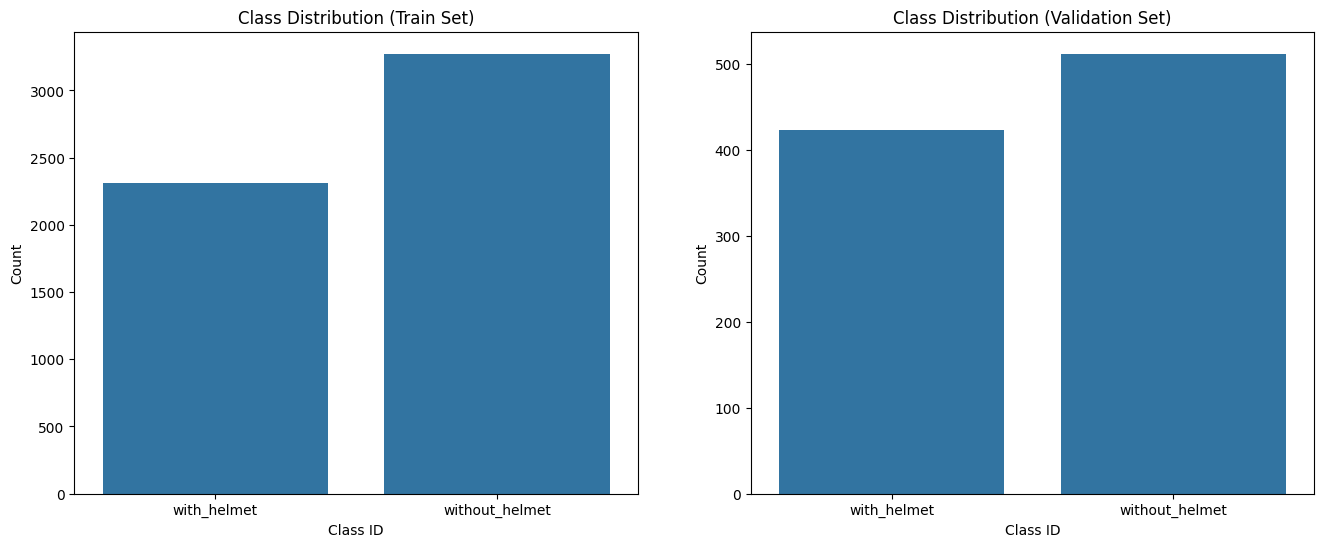

In [6]:
# Class distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(x=list(train_classes.keys()), y=list(train_classes.values()), ax=axes[0])
axes[0].set_xlabel("Class ID")
axes[0].set_ylabel("Count")
axes[0].set_title("Class Distribution (Train Set)")

sns.barplot(x=list(val_classes.keys()), y=list(val_classes.values()), ax=axes[1])
axes[1].set_xlabel("Class ID")
axes[1].set_ylabel("Count")
axes[1].set_title("Class Distribution (Validation Set)")

plt.show()

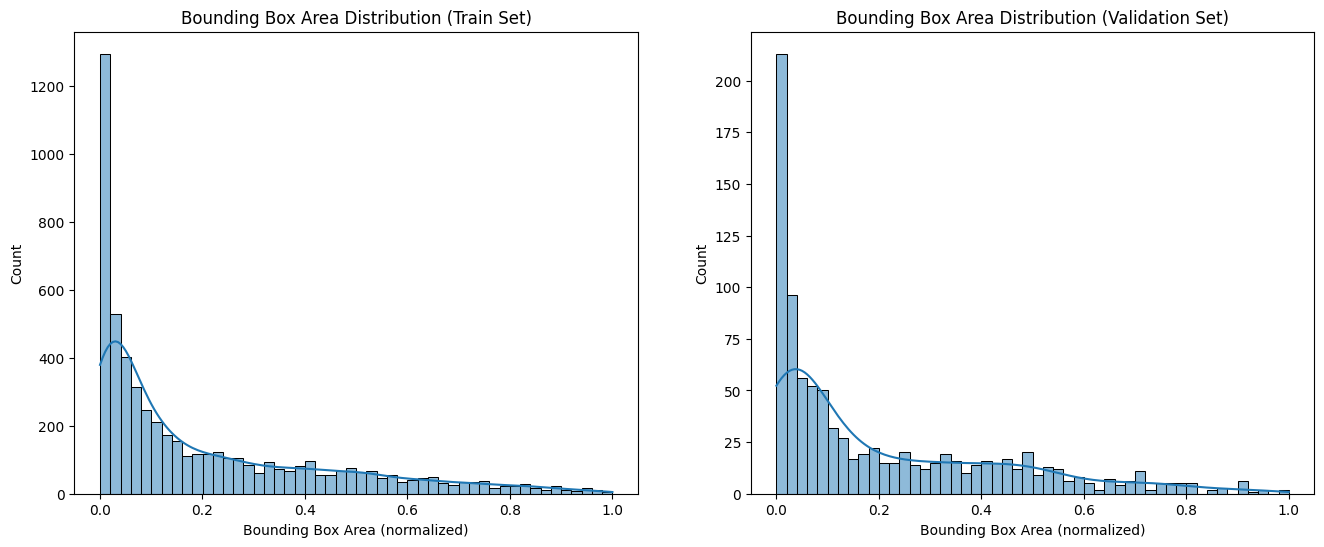

In [5]:
# Bounding box size distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(train_bboxes[:, 0] * train_bboxes[:, 1], bins=50, kde=True, ax=axes[0])
axes[0].set_xlabel("Bounding Box Area (normalized)")
axes[0].set_ylabel("Count")
axes[0].set_title("Bounding Box Area Distribution (Train Set)")

sns.histplot(val_bboxes[:, 0] * val_bboxes[:, 1], bins=50, kde=True, ax=axes[1])
axes[1].set_xlabel("Bounding Box Area (normalized)")
axes[1].set_ylabel("Count")
axes[1].set_title("Bounding Box Area Distribution (Validation Set)")

plt.show()

## Visualizations from Train Set

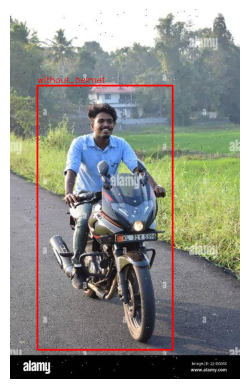

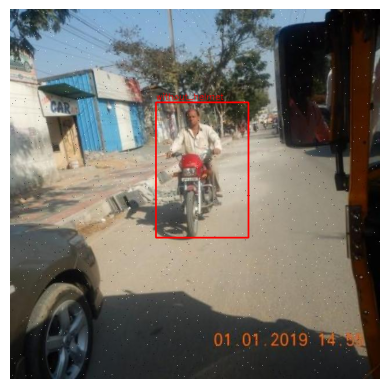

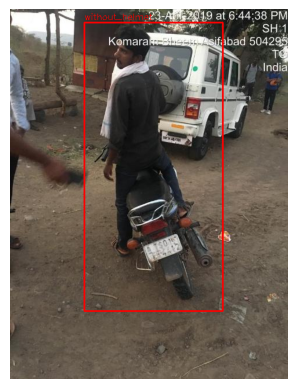

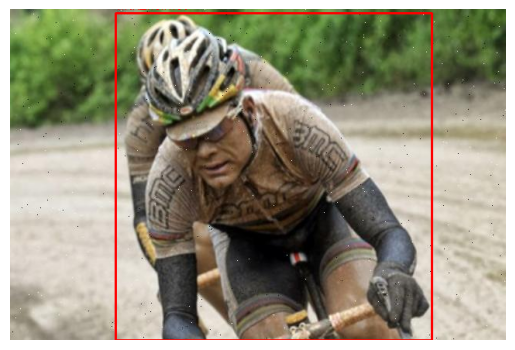

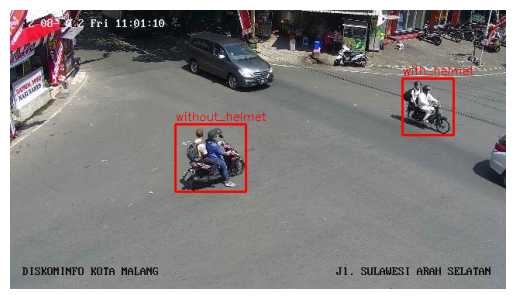

In [ ]:
# Function to visualize random images with bounding boxes
def plot_image_with_bboxes(image_path, label_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    with open(label_path, "r") as file:
        lines = file.readlines()
        for line in lines:
            data = line.strip().split()
            if len(data) == 5:
                class_id, x, y, bw, bh = map(float, data)
                x1 = int((x - bw / 2) * w)
                y1 = int((y - bh / 2) * h)
                x2 = int((x + bw / 2) * w)
                y2 = int((y + bh / 2) * h)
                cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                cv2.putText(img, class_id_map[int(class_id)], (x1, y1-5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    # plt.figure(figsize=(8,6))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

# Plot 5 random images with annotations
sample_images = random.sample(list(train_images), 5)
for img_name in sample_images:
    img_path = os.path.join(train_images_dir, img_name)
    label_path = os.path.join(train_labels_dir, img_name.replace(".jpg", ".txt"))
    if os.path.exists(label_path):
        plot_image_with_bboxes(img_path, label_path)

## Training YOLO models

In [ ]:
!yolo detect train data=data.yaml model=yolov8m.pt imgsz=640 epochs=100 patience=5 device=1

The parameters mentioned above were used to train different YOLO models, rest parameters were default as per Ultralytics.  
  
All parameters:  
`engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=data.yaml, epochs=100, time=None, patience=5, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=1, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=True, opset=None, workspace=None, nms=False, lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=7.5, cls=0.5, dfl=1.5, pose=12.0, kobj=1.0, nbs=64, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1, scale=0.5, shear=0.0, perspective=0.0, flipud=0.0, fliplr=0.5, bgr=0.0, mosaic=1.0, mixup=0.0, copy_paste=0.0, copy_paste_mode=flip, auto_augment=randaugment, erasing=0.4, crop_fraction=1.0, cfg=None, tracker=botsort.yaml, save_dir=runs/detect/train`  
`Overriding model.yaml nc=80 with nc=2`

## Training Statistics on Train Set and Results on Validation Set:

| YOLO Model | GPU Memory | Early Stopping at Epoch | with helmet (P, R, mAP50-95) | without helmet (P, R, mAP50-95) | all classes (P, R, mAP50-95) |
|------|---------|----|--------------------------------|--------------------------------|--------------------------------|
| v8m  | 8.25 GB | 26 | 0.71, 0.655, <ins>0.442</ins>  | 0.794, 0.748, <ins>0.535</ins> | 0.752, 0.701, <ins>0.489</ins> |
| v8l  | 11.7 GB | 31 | 0.732, 0.674, 0.441            | 0.805, 0.715, 0.53             | <ins>0.769</ins>, 0.694, 0.485 |
| v9m  | 9.56 GB | 26 | 0.743, 0.61, 0.431             | 0.661, <ins>0.798</ins>, 0.526 | 0.702, <ins>0.704</ins>, 0.479 |
| v9c  | 12.3 GB | 28 | 0.621, <ins>0.683</ins>, 0.432 | <ins>0.823</ins>, 0.678, 0.519 | 0.722, 0.68, 0.475             |
| v10m | 10.3 GB | 31 | <ins>0.751</ins>, 0.585, 0.416 | 0.755, 0.715, 0.511            | 0.753, 0.65, 0.464             |
| v10b | 13.2 GB | 34 | 0.673, 0.642, 0.428            | 0.799, 0.672, 0.518            | 0.736, 0.657, 0.473            |
| v10l | 15.1 GB | 21 | 0.684, 0.596, 0.398            | 0.763, 0.661, 0.503            | 0.724, 0.628, 0.45             |
| v11m | 10 GB   | 24 | 0.671, 0.655, 0.423            | 0.806, 0.655, 0.492            | 0.739, 0.655, 0.457            |
| v11l | 12.2 GB | 39 | 0.7, 0.674, 0.433              | 0.807, 0.724, 0.529            | 0.754, 0.699, 0.481            |